In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pickle


In [10]:
# выгрузка данных
df = pd.read_csv('../data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
df.shape

(20640, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952

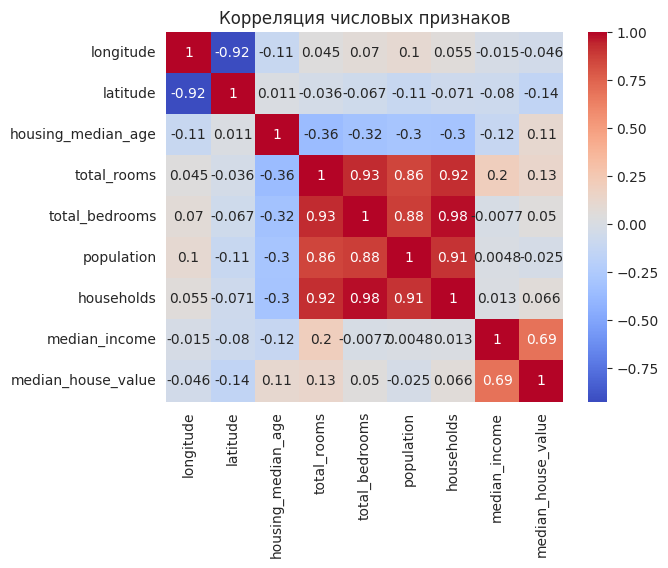

In [13]:
print(df.info())
print(df.describe())
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция числовых признаков')
plt.show()



In [14]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   ocean_proximity_INLAND      20640 non-null  bool   
 10  ocean_proximity_ISLAND      20640 non-null  bool   
 11  ocean_proximity_NEAR BAY    20640 non-null  bool   
 12  ocean_proximity_NEAR OCEAN  20640 non-null  bool   
dtypes: bool(4), float64(9)
memory u

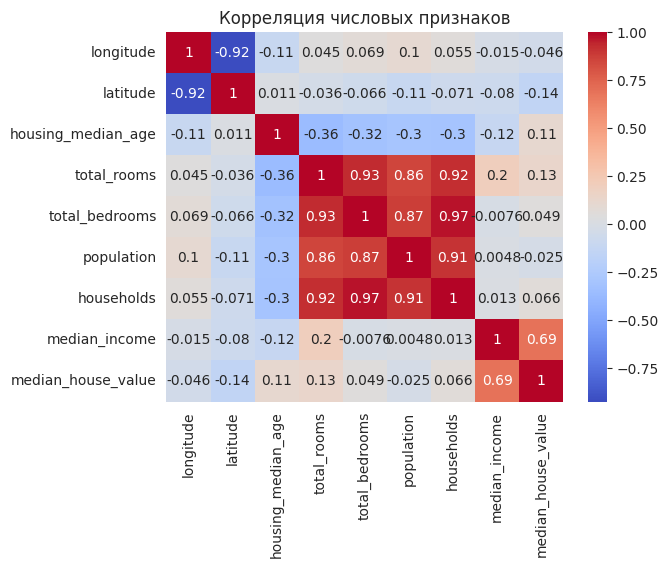

In [15]:
print(df.info())
print(df.describe())
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция числовых признаков')
plt.show()



In [16]:
#
print("Количество дубликатов до очистки:", df.duplicated().sum())


df = df.drop_duplicates()

print("Количество дубликатов после очистки:", df.duplicated().sum())
print("Новая форма данных:", df.shape)


Количество дубликатов до очистки: 0
Количество дубликатов после очистки: 0
Новая форма данных: (20640, 13)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest — MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")


Random Forest — MAE: 31639.37, R²: 0.82


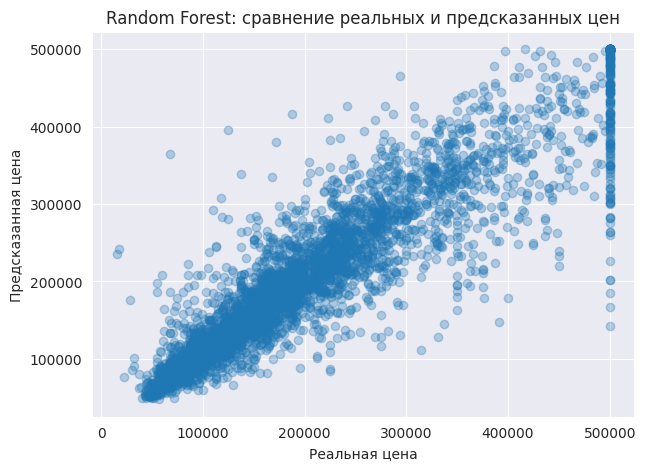

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.title('Random Forest: сравнение реальных и предсказанных цен')
plt.show()


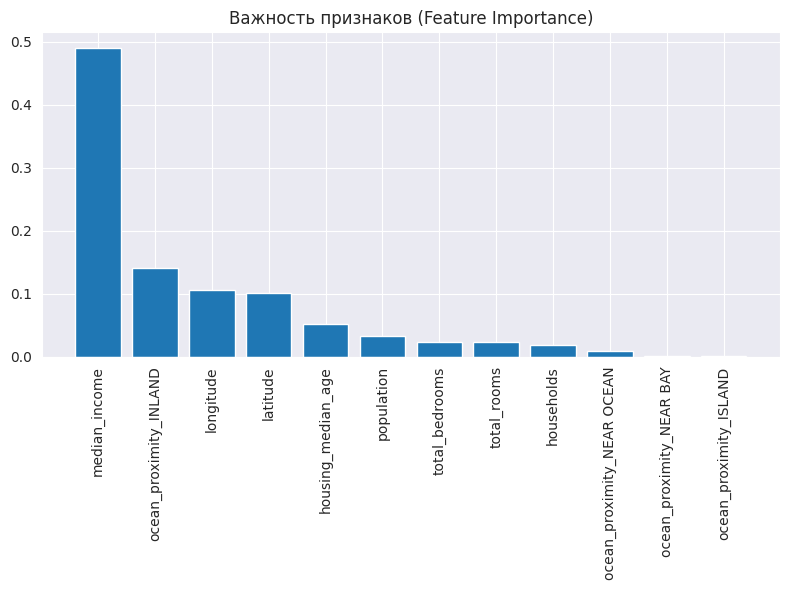

In [20]:
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(8,6))
plt.title('Важность признаков (Feature Importance)')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [22]:
# тюнинг модели при помощи GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Базовая модель
rf = RandomForestRegressor(random_state=42)

# Сетка параметров для подбора
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                # 3-кратная кросс-валидация
    n_jobs=-1,           # использовать все ядра процессора
    verbose=2,           # показывать процесс
    scoring='r2'         # метрика качества
)


In [23]:
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [24]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший R² на кросс-валидации:", grid_search.best_score_)


Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Лучший R² на кросс-валидации: 0.8110188776748792


In [25]:
best_model = grid_search.best_estimator_

from sklearn.metrics import mean_absolute_error, r2_score

y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Оптимизированный Random Forest — MAE: {mae_best:.2f}, R²: {r2_best:.2f}")


Оптимизированный Random Forest — MAE: 32915.81, R²: 0.81


In [26]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']


In [27]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()


In [28]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

best_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

best_rf.fit(X_train, y_train)

y_pred_rf = best_rf.predict(X_test)


In [30]:
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


MAE: 33510.95
R²: 0.81


In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting — MAE: {mae_gbr:.2f}, R²: {r2_gbr:.2f}")


Gradient Boosting — MAE: 32299.27, R²: 0.82


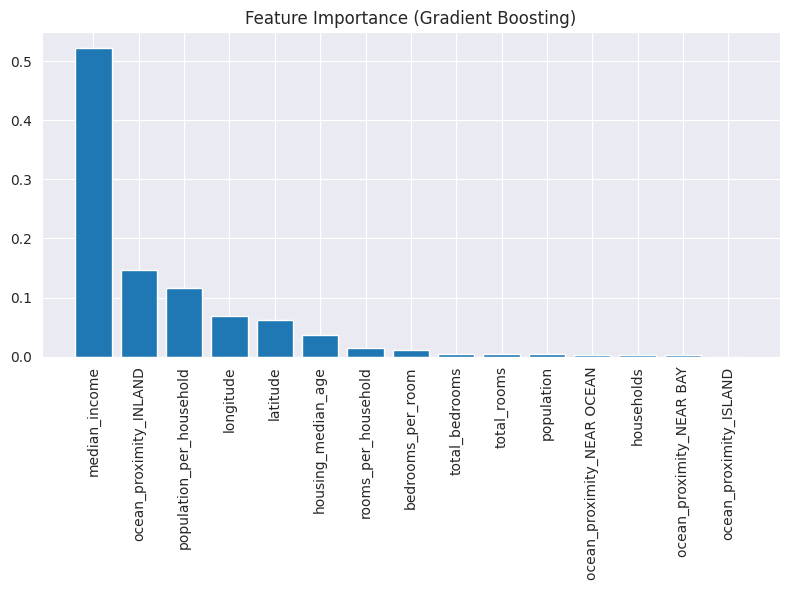

In [32]:
import matplotlib.pyplot as plt
import numpy as np

importances = gbr.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
plt.title('Feature Importance (Gradient Boosting)')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


In [34]:
import pickle

# сохраняем модель
with open('../model/gradient_boosting_model.pkl', 'wb') as file:
    pickle.dump(gbr, file)

print(" Модель успешно сохранена в '../model/gradient_boosting_model.pkl'")


 Модель успешно сохранена в '../model/gradient_boosting_model.pkl'


In [38]:
import pickle
import numpy as np
import pandas as pd

# загружаем модель
with open('../model/gradient_boosting_model.pkl', 'rb') as file:
    model = pickle.load(file)

# пример входных данных (можно заменить своими)
sample = pd.DataFrame([{
    'longitude': -122.23,
    'latitude': 37.88,
    'housing_median_age': 41,
    'total_rooms': 880,
    'total_bedrooms': 129,
    'population': 322,
    'households': 126,
    'median_income': 8.3252,
    'ocean_proximity_INLAND': False,
    'ocean_proximity_ISLAND': False,
    'ocean_proximity_NEAR BAY': True,
    'ocean_proximity_NEAR OCEAN': False,
    'rooms_per_household': 880 / 126,
    'bedrooms_per_room': 129 / 880,
    'population_per_household': 322 / 126
}])

# прогноз
pred = model.predict(sample)
print(f" Прогнозируемая цена дома: ${pred[0]:,.2f}")


 Прогнозируемая цена дома: $415,494.50
